In [11]:
import os

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import regionmask

import pandas as pd
import geopandas as gpd
import dask_geopandas as dgpd
from shapely.geometry import Point
from dask import dataframe as dd
from mpl_toolkits.basemap import Basemap

import polars as pl
import gc 
import pyarrow as pa



%matplotlib inline

In [12]:
# ds = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/power_nasa_data.nc')
ds = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/power_nasa_data.nc')


In [13]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:            (time: 8501, lat: 69, lon: 47)
Coordinates:
  * time               (time) datetime64[ns] 68kB 2001-01-01 ... 2024-04-10
  * lat                (lat) float64 552B -12.0 -11.5 -11.0 ... 21.0 21.5 22.0
  * lon                (lon) float64 376B 23.12 23.75 24.38 ... 51.25 51.88
Data variables: (12/14)
    PRECTOTCORR        (time, lat, lon) float64 221MB ...
    EVPTRNS            (time, lat, lon) float64 221MB ...
    T2M                (time, lat, lon) float64 221MB ...
    TS                 (time, lat, lon) float64 221MB ...
    PS                 (time, lat, lon) float64 221MB ...
    WS2M               (time, lat, lon) float64 221MB ...
    ...                 ...
    RH2M               (time, lat, lon) float64 221MB ...
    GWETROOT           (time, lat, lon) float64 221MB ...
    GWETPROF           (time, lat, lon) float64 221MB ...
    GWETTOP            (time, lat, lon) float64 221MB ...
    CLOUD_AMT          (time, lat, lon) float64 221MB ...
    ALLSKY_SFC_SW_DWN  (time, lat, lon) float64 221MB ...

In [14]:
df_pandas = ds.to_dataframe().reset_index()

# Close the dataset
ds.close()


In [15]:
df_pandas.head()

,time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
0,2001-01-01,-12.0,23.125,0.000106,22.726562,294.000000,293.984375,88246.3125,1.726562,2.812500,0.015747,90.2500,0.531250,0.539062,0.632812,79.132812,241.062500
1,2001-01-01,-12.0,23.750,0.000124,20.921875,292.921875,292.960938,86559.8125,1.953125,3.023438,0.015320,91.8750,0.726562,0.718750,0.789062,82.492188,226.062500
2,2001-01-01,-12.0,24.375,0.000106,37.718750,293.179688,293.382812,86069.8125,2.148438,3.265625,0.015076,89.0000,0.710938,0.710938,0.765625,85.851562,211.062500
3,2001-01-01,-12.0,25.000,0.000123,31.492188,293.117188,293.156250,86109.6250,1.898438,2.945312,0.014832,87.8750,0.789062,0.804688,0.843750,89.787109,215.322266
4,2001-01-01,-12.0,25.625,0.000163,31.187500,292.976562,293.062500,86180.1250,1.445312,2.523438,0.014709,88.0625,0.804688,0.820312,0.851562,93.368164,220.222656


In [16]:
# Convert the Pandas DataFrame to a Polars DataFrame
df_polars = pl.from_pandas(df_pandas)


In [17]:
del df_pandas
gc.collect()

78

In [18]:
df_polars

time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01 00:00:00,-12.0,23.125,0.000106,22.726562,294.0,293.984375,88246.3125,1.7265625,2.8125,0.015747,90.25,0.53125,0.5390625,0.6328125,79.132812,241.0625
2001-01-01 00:00:00,-12.0,23.75,0.000124,20.921875,292.921875,292.960938,86559.8125,1.953125,3.0234375,0.01532,91.875,0.7265625,0.71875,0.7890625,82.492188,226.0625
2001-01-01 00:00:00,-12.0,24.375,0.000106,37.71875,293.179688,293.382812,86069.8125,2.1484375,3.265625,0.015076,89.0,0.7109375,0.7109375,0.765625,85.851562,211.0625
2001-01-01 00:00:00,-12.0,25.0,0.000123,31.492188,293.117188,293.15625,86109.625,1.8984375,2.9453125,0.014832,87.875,0.7890625,0.8046875,0.84375,89.787109,215.322266
2001-01-01 00:00:00,-12.0,25.625,0.000163,31.1875,292.976562,293.0625,86180.125,1.4453125,2.5234375,0.014709,88.0625,0.8046875,0.8203125,0.8515625,93.368164,220.222656
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-04-10 00:00:00,22.0,49.375,0.000022,null,300.671875,301.4375,98521.5625,4.671875,6.0,0.011292,49.1875,null,null,null,null,null
2024-04-10 00:00:00,22.0,50.0,0.000011,null,301.601562,302.507812,98796.25,4.6640625,5.9765625,0.010681,44.3125,null,null,null,null,null
2024-04-10 00:00:00,22.0,50.625,0.00001,null,302.289062,303.375,99146.875,4.515625,5.765625,0.010254,41.3125,null,null,null,null,null


In [19]:
def calculate_missing_percentages(df: pl.DataFrame) -> pl.DataFrame:
    """
    Calculates the percentage of missing values in each column of a Polars DataFrame.

    Parameters:
    - df (pl.DataFrame): The input DataFrame with potentially missing values.

    Returns:
    - pl.DataFrame: A DataFrame with one row showing the percentage of missing values for each column.

    Example of usage:
    missing_percentages = calculate_missing_percentages(polars_df)
    print(missing_percentages)
    """
    total_rows = df.height  # Access the number of rows in the DataFrame
    missing_counts = df.select([pl.col(column).is_null().sum().alias(column) for column in df.columns])
    missing_percentage = missing_counts / total_rows * 100
    
    return missing_percentage

# Example usage 
# missing_percentages = calculate_missing_percentages(df_polars)

In [20]:
missing_percentages = calculate_missing_percentages(df_polars)
missing_percentages

time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,22.26359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.26359,22.26359,1.176332,1.176332,1.176332


In [21]:
# Drop rows where any cell has NaN
clean_df = df_polars.drop_nulls()

In [22]:
clean_df

time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01 00:00:00,-12.0,23.125,0.000106,22.726562,294.0,293.984375,88246.3125,1.7265625,2.8125,0.015747,90.25,0.53125,0.5390625,0.6328125,79.132812,241.0625
2001-01-01 00:00:00,-12.0,23.75,0.000124,20.921875,292.921875,292.960938,86559.8125,1.953125,3.0234375,0.01532,91.875,0.7265625,0.71875,0.7890625,82.492188,226.0625
2001-01-01 00:00:00,-12.0,24.375,0.000106,37.71875,293.179688,293.382812,86069.8125,2.1484375,3.265625,0.015076,89.0,0.7109375,0.7109375,0.765625,85.851562,211.0625
2001-01-01 00:00:00,-12.0,25.0,0.000123,31.492188,293.117188,293.15625,86109.625,1.8984375,2.9453125,0.014832,87.875,0.7890625,0.8046875,0.84375,89.787109,215.322266
2001-01-01 00:00:00,-12.0,25.625,0.000163,31.1875,292.976562,293.0625,86180.125,1.4453125,2.5234375,0.014709,88.0625,0.8046875,0.8203125,0.8515625,93.368164,220.222656
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-01-01 00:00:00,22.0,49.375,0.0,0.15625,294.039062,295.007812,99338.5625,1.625,2.53125,0.008545,57.9375,0.1484375,0.1484375,0.171875,14.348145,181.06543
2024-01-01 00:00:00,22.0,50.0,0.0,0.46875,294.34375,295.53125,99628.25,1.6953125,2.5625,0.00885,59.375,0.1484375,0.1484375,0.1328125,15.677734,177.796875
2024-01-01 00:00:00,22.0,50.625,0.0,0.5390625,294.796875,296.164062,99977.5625,1.9140625,2.7734375,0.009094,59.5,0.140625,0.1484375,0.125,17.001953,175.021484


In [23]:
missing_percentages = calculate_missing_percentages(clean_df)
missing_percentages

time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
def plot_geographical_data(polars_df: pl.DataFrame):
    """
    Plots unique geographical data points on a map from a Polars DataFrame containing latitude and longitude.

    Parameters:
    - polars_df (pl.DataFrame): A Polars DataFrame with 'lat' and 'lon' columns.

    Author:
    - Adam Przychodni
    """
    # Ensure the DataFrame has the necessary columns
    if not {'lat', 'lon'}.issubset(polars_df.columns):
        raise ValueError("DataFrame must contain 'lat' and 'lon' columns")

    # Select the latitude and longitude columns and get unique pairs
    unique_coords = polars_df.select(['lat', 'lon']).unique()

    # Extract longitude and latitude columns from the unique coordinates
    lons = unique_coords.get_column('lon').to_numpy()
    lats = unique_coords.get_column('lat').to_numpy()

    # Set up the plot with a specified size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a Basemap instance with a cylindrical projection
    m = Basemap(projection='cyl', llcrnrlon=lons.min() - 1, llcrnrlat=lats.min() - 1,
                urcrnrlon=lons.max() + 1, urcrnrlat=lats.max() + 1, resolution='i', ax=ax)

    # Draw coastlines and countries for better map visualization
    m.drawcoastlines()
    m.drawcountries()

    # Convert latitude and longitude to map projection coordinates
    x, y = m(lons, lats)

    # Plot the data points with a green color, 'o' marker, and size of 60
    m.scatter(x, y, color='green', label='Unique Data Points', marker='o', s=60)

    # Add a legend and a title to the plot
    plt.legend()
    plt.title('Geographical Plot of Unique Data Points')

    # Display the plot
    plt.show()

    # Close the plot to free up memory
    plt.close(fig)
    
    # Explicitly delete variables and collect garbage
    del m, x, y, lons, lats, unique_coords, fig, ax
    gc.collect()


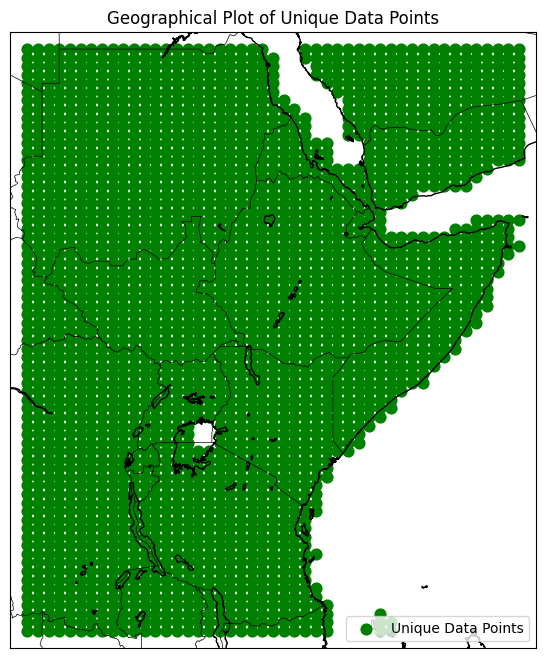

In [25]:
# Example usage:
# Assuming 'df' is your Polars DataFrame loaded with latitude and longitude data
plot_geographical_data(clean_df)

Latency in CERES they providing data with 3-4 months delay

In [26]:
# import pygadm
# import geopandas as gpd
# import pandas as pd

# # List of countries and their GADM codes
# countries_codes = {
#     "Rwanda": "RWA", 
#     "Burundi": "BDI",
#     "Tanzania": "TZA",
#     "Uganda": "UGA",
#     "Kenya": "KEN",
#     "Somalia": "SOM",
#     "Ethiopia": "ETH",
#     "Eritrea": "ERI",
#     "Djibouti": "DJI",
#     "Sudan": "SDN",
#     "South Sudan": "SSD"
# }

# # Initialize an empty list to store GeoDataFrames
# country_gdfs = []

# # Loop through the dictionary, retrieve data for each country and append to the list
# for name, code in countries_codes.items():
#     gdf = pygadm.Items(admin=code)
#     country_gdfs.append(gdf)

# # Concatenate all GeoDataFrames into one
# all_countries_gdf = pd.concat(country_gdfs, ignore_index=True)

# all_countries_gdf


In [27]:
# all_countries_gdf.to_file("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/countries.geojson", driver='GeoJSON')

In [28]:
gdf = gpd.read_file("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/countries.geojson")

In [29]:
gdf

,GID_0,NAME_0,geometry
0,RWA,Rwanda,"MULTIPOLYGON (((29.71330 -2.81760, 29.70820 -2..."
1,BDI,Burundi,"MULTIPOLYGON (((30.04520 -4.25680, 30.04730 -4..."
2,TZA,Tanzania,"MULTIPOLYGON (((39.35590 -11.09160, 39.34140 -..."
3,UGA,Uganda,"MULTIPOLYGON (((29.91130 -1.47690, 29.90310 -1..."
4,KEN,Kenya,"MULTIPOLYGON (((39.38010 -4.71790, 39.37740 -4..."
5,SOM,Somalia,"MULTIPOLYGON (((45.08960 1.90760, 45.09100 1.9..."
6,ETH,Ethiopia,"MULTIPOLYGON (((38.43720 3.60130, 38.34170 3.6..."
7,ERI,Eritrea,"MULTIPOLYGON (((42.93320 12.81850, 42.93150 12..."
8,DJI,Djibouti,"MULTIPOLYGON (((43.08340 11.18200, 43.00130 11..."
9,SDN,Sudan,"MULTIPOLYGON (((24.22410 8.70360, 24.21620 8.6..."


In [30]:
import polars as pl
import geopandas as gpd
from shapely.geometry import Point

def filter_dataframe_by_country(df, gdf):
    """
    Filters a Polars DataFrame based on country polygons.

    Parameters:
    - df (pl.DataFrame): Input Polars DataFrame with 'lat' and 'lon' columns.
    - gdf (gpd.GeoDataFrame): GeoDataFrame with country polygons.

    Returns:
    - pl.DataFrame: Filtered DataFrame with entries only within specified countries.
    """
    # Ensure gdf has a defined CRS
    if gdf.crs is None:
        gdf.set_crs("EPSG:4326", inplace=True)
    elif gdf.crs.to_string() != 'EPSG:4326':
        gdf = gdf.to_crs("EPSG:4326")

    # Convert Polars DataFrame to Pandas DataFrame to create GeoDataFrame
    unique_coords = df.select(['lat', 'lon']).unique().to_pandas()
    points_gdf = gpd.GeoDataFrame(unique_coords, geometry=[Point(xy) for xy in zip(unique_coords['lon'], unique_coords['lat'])], crs="EPSG:4326")

    # Spatial join to find points within the country polygons
    valid_points = gpd.sjoin(points_gdf, gdf, how="inner", predicate='intersects')
    valid_points_df = pl.from_pandas(valid_points[['lat', 'lon']])
    
    # Filter original DataFrame
    filtered_df = df.join(valid_points_df, on=['lat', 'lon'], how='semi')

    return filtered_df

# Example usage assuming 'clean_df' is your Polars DataFrame and 'gdf' is loaded using pygadm.Items
filtered_df = filter_dataframe_by_country(clean_df, gdf)


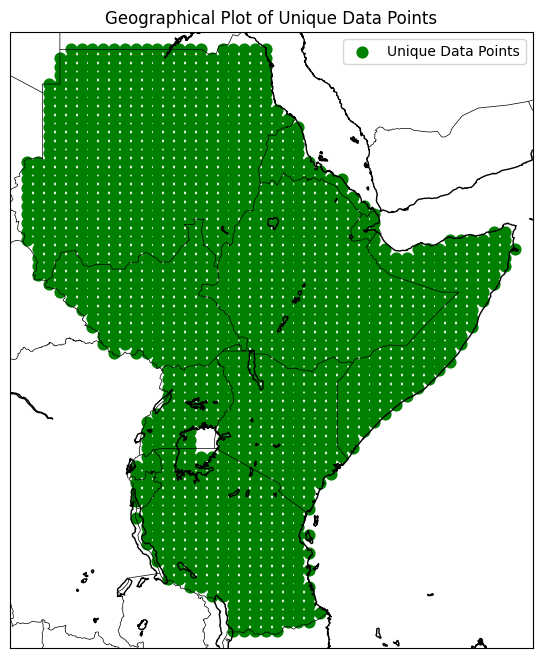

In [31]:
plot_geographical_data(filtered_df)

In [32]:
filtered_df

time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01 00:00:00,-11.5,35.0,0.000011,35.578125,298.554688,300.203125,92057.3125,1.9765625,2.5234375,0.015808,72.1875,0.640625,0.6328125,0.65625,94.207031,178.519531
2001-01-01 00:00:00,-11.5,35.625,0.000018,74.953125,298.234375,298.835938,93466.0,1.859375,2.8046875,0.016235,77.8125,0.671875,0.6640625,0.6875,96.116211,186.345703
2001-01-01 00:00:00,-11.5,36.25,0.000031,65.9375,298.101562,298.679688,94211.625,2.4140625,3.515625,0.016052,78.3125,0.6796875,0.671875,0.6953125,94.080078,186.628906
2001-01-01 00:00:00,-11.5,36.875,0.000047,67.171875,298.015625,298.59375,95146.0,2.6484375,3.8125,0.016296,80.4375,0.6875,0.671875,0.703125,92.205078,197.992188
2001-01-01 00:00:00,-11.5,37.5,0.000044,46.96875,298.054688,298.46875,96108.0,2.6015625,3.8203125,0.016663,82.25,0.6171875,0.59375,0.6640625,90.4375,216.742188
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-01-01 00:00:00,22.0,34.375,0.0,0.015625,292.664062,293.992188,96891.25,2.0546875,3.078125,0.007141,53.375,0.2578125,0.2578125,0.1875,0.15625,213.762695
2024-01-01 00:00:00,22.0,35.0,1.1642e-10,0.0,291.664062,293.1875,94504.25,2.03125,2.9609375,0.008423,64.9375,0.3125,0.3125,0.2421875,0.650391,213.164062
2024-01-01 00:00:00,22.0,35.625,0.0,0.0,291.664062,293.882812,94149.25,2.4140625,3.2890625,0.009277,70.25,0.3203125,0.3203125,0.1640625,1.822266,211.628906


In [33]:
def convert_precip_kgms_to_mm(df, column_name):
    """
    Converts precipitation data from kg/m^2/s to mm/day within a Polars DataFrame.

    Parameters:
    - df (pl.DataFrame): Polars DataFrame containing the precipitation data.
    - column_name (str): Name of the column with precipitation values in kg/m^2/s.

    Returns:
    - pl.DataFrame: Polars DataFrame with an additional column for precipitation in mm/day.
    """
    seconds_per_day = 86400  # Number of seconds in a day
    # Calculate precipitation in mm and add as a new column
    df = df.with_columns(
        (df[column_name] * seconds_per_day).alias(f"{column_name}_mm")
    )
    df = df.drop('PRECTOTCORR')
    return df

# Example usage:
updated_df = convert_precip_kgms_to_mm(filtered_df, 'PRECTOTCORR')


This conversion transforms precipitation data from the rate of kilograms per square meter per second to the equivalent amount of millimeters per day.

In [26]:
updated_df

time,lat,lon,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN,PRECTOTCORR_mm
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01 00:00:00,-11.5,35.0,35.578125,298.554688,300.203125,92057.3125,1.9765625,2.5234375,0.015808,72.1875,0.640625,0.6328125,0.65625,94.207031,178.519531,0.951856
2001-01-01 00:00:00,-11.5,35.625,74.953125,298.234375,298.835938,93466.0,1.859375,2.8046875,0.016235,77.8125,0.671875,0.6640625,0.6875,96.116211,186.345703,1.583561
2001-01-01 00:00:00,-11.5,36.25,65.9375,298.101562,298.679688,94211.625,2.4140625,3.515625,0.016052,78.3125,0.6796875,0.671875,0.6953125,94.080078,186.628906,2.690817
2001-01-01 00:00:00,-11.5,36.875,67.171875,298.015625,298.59375,95146.0,2.6484375,3.8125,0.016296,80.4375,0.6875,0.671875,0.703125,92.205078,197.992188,4.040025
2001-01-01 00:00:00,-11.5,37.5,46.96875,298.054688,298.46875,96108.0,2.6015625,3.8203125,0.016663,82.25,0.6171875,0.59375,0.6640625,90.4375,216.742188,3.829511
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-01-01 00:00:00,22.0,34.375,0.015625,292.664062,293.992188,96891.25,2.0546875,3.078125,0.007141,53.375,0.2578125,0.2578125,0.1875,0.15625,213.762695,0.0
2024-01-01 00:00:00,22.0,35.0,0.0,291.664062,293.1875,94504.25,2.03125,2.9609375,0.008423,64.9375,0.3125,0.3125,0.2421875,0.650391,213.164062,0.00001
2024-01-01 00:00:00,22.0,35.625,0.0,291.664062,293.882812,94149.25,2.4140625,3.2890625,0.009277,70.25,0.3203125,0.3203125,0.1640625,1.822266,211.628906,0.0


In [36]:
# Convert T2M from Kelvin to Celsius
updated_df = updated_df.with_columns(
    (updated_df["T2M"] - 273.15).alias("T2M")
)

In [37]:
updated_df

time,lat,lon,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN,PRECTOTCORR_mm
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01 00:00:00,-11.5,35.0,35.578125,25.404688,300.203125,92057.3125,1.9765625,2.5234375,0.015808,72.1875,0.640625,0.6328125,0.65625,94.207031,178.519531,0.951856
2001-01-01 00:00:00,-11.5,35.625,74.953125,25.084375,298.835938,93466.0,1.859375,2.8046875,0.016235,77.8125,0.671875,0.6640625,0.6875,96.116211,186.345703,1.583561
2001-01-01 00:00:00,-11.5,36.25,65.9375,24.951563,298.679688,94211.625,2.4140625,3.515625,0.016052,78.3125,0.6796875,0.671875,0.6953125,94.080078,186.628906,2.690817
2001-01-01 00:00:00,-11.5,36.875,67.171875,24.865625,298.59375,95146.0,2.6484375,3.8125,0.016296,80.4375,0.6875,0.671875,0.703125,92.205078,197.992188,4.040025
2001-01-01 00:00:00,-11.5,37.5,46.96875,24.904688,298.46875,96108.0,2.6015625,3.8203125,0.016663,82.25,0.6171875,0.59375,0.6640625,90.4375,216.742188,3.829511
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-01-01 00:00:00,22.0,34.375,0.015625,19.514063,293.992188,96891.25,2.0546875,3.078125,0.007141,53.375,0.2578125,0.2578125,0.1875,0.15625,213.762695,0.0
2024-01-01 00:00:00,22.0,35.0,0.0,18.514063,293.1875,94504.25,2.03125,2.9609375,0.008423,64.9375,0.3125,0.3125,0.2421875,0.650391,213.164062,0.00001
2024-01-01 00:00:00,22.0,35.625,0.0,18.514063,293.882812,94149.25,2.4140625,3.2890625,0.009277,70.25,0.3203125,0.3203125,0.1640625,1.822266,211.628906,0.0


In [38]:
# Save the DataFrame with compression
updated_df.write_parquet("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_power_nasa_data.parquet", compression="snappy")

In [ ]:
# # Create unique indices for each country if not already unique
# gdf['country_index'] = range(len(gdf))

# countries_mask = regionmask.Regions(
#     outlines=gdf['geometry'].values,
#     names=gdf['NAME_0'].values,
#     numbers=gdf['country_index'].values,  # Use the new unique index
#     abbrevs=gdf['GID_0'].values
# )

# # Generate the mask
# mask = countries_mask.mask(ds['lon'], ds['lat'], wrap_lon=True)

# # Apply the mask to the dataset
# masked_dataset = ds.where(mask.notnull())

In [1]:
# import polars as pl
# import pandas as pd
# import xarray as xr

# # Assuming 'filtered_df' is your initial Polars DataFrame
# pdf = filtered_df.to_pandas()

In [2]:
# pdf.head()

In [3]:
# # Sort and set MultiIndex without filling every possible combination
# pdf.sort_values(['time', 'lat', 'lon'], inplace=True)
# pdf.set_index(['time', 'lat', 'lon'], inplace=True)


In [4]:
# pdf

In [5]:
# Convert the DataFrame to xarray
# ds = pdf.to_xarray()

In [6]:
# ds

In [7]:
# # Define compression settings
# compression_opts = {'zlib': True, 'complevel': 5}  # You can adjust the compression level from 1 to 9

# # Apply the compression to each variable in the dataset
# encoding = {var: compression_opts for var in ds_filtered.variables}

# # Export the region as a compressed NetCDF4 file
# ds_filtered.to_netcdf(
#     path=os.path.join("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_power_nasa_data.nc"),
#     encoding=encoding
# )
